# トークトリアル 11 (パート A)

# オンラインAPI/サーバーを使った構造に基づくCADD

__Developed at AG Volkamer, Charité__

Dr. Jaime Rodríguez-Guerra, Dominique Sydow

## このトークトリアルの目的

>  これは「オンラインWebサービス」についてのトークトリアルのパートAです。:
>
> - 11a. __キナーゼ阻害剤の候補をKLIFとPubChemで検索__
> - 11b. 11aで取得した候補化合物をターゲットタンパク質に対してドッキング
> - 11c. 結果を評価し既知のデータと比較

KLIFデータベースにクエリを投げ、キナーゼの構造と阻害剤を一つ取得します。それから、PubChemで類似の化合物を検索します。

## 学習の目標

### 理論

- パイプラインと含まれているWebサービスの解説

### 実践

- パイプラインを構成する関数を書く
- ケーススタディー：EGFR阻害剤


## レファレンス

* KLIFS：キナーゼー阻害剤相互作用データベース
   * データベースそのものの解説 ([_J. Med. Chem._ (2014), __57__, 2, 249-277](https://pubs.acs.org/doi/abs/10.1021/jm400378w))
   * オンラインサービスの解説 ([_Nucleic Acids Res._ (2016), __44__, 6, D365–D371](https://doi.org/10.1093/nar/gkv1082))
* PubChem：低分子化合物のデータベース([_Nucleic Acids Res._ (2019), __47__, D1102-1109](https://academic.oup.com/nar/article/47/D1/D1102/5146201))
* NGLView：Notebookのためのインタラクティブな可視化ソフト([_Bioinformatics_ (2018), __34__, 1241–124](https://doi.org/10.1093/bioinformatics/btx789))

***


## 理論

ここまでで、さまざまなPythonライブラリをつかってオンラインWebサービスにクエリを投げる方法をみてきました。オンラインWebサービスからパイプラインを構築してみましょう！

### パイプラインと含まれているWebサービスの解説

1. キナーゼーリガンド相互作用フィンガープリントと構造のデータベース（KLIFS: Kinase-Ligand Interaction Fingerprints and Structures database）はアムステルダムのVU大学医薬品化学分野で開発されたデータベースで、触媒キナーゼドメインのタンパク質構造に関する情報（PDBから収集）と、リガンドとの相互作用に関する情報とを提供しています。このデータベースから精選されたタンパク質構造を取得し、そのリガンドの情報をつかってPubChemやChEMBLといった他のデータベースから類似したリガンドを取得することができます。
2. KLIFによるリガンド情報を使って、PubChemで類似化合物を探します。
3. タンパク質構造と候補となるリガンドをいくつか手に入れたら、OPALWebサービスで提供されている組み込みのVinaを使ってオンラインでドッキングを実施します。また、_proteins.plus'_ DoGSiteScorerで化合物をドッキングする結合サイトの候補を探します。（パート　B）
4. 結果を`nglview`で可視化し、相互作用を [PLIP](https://github.com/ssalentin/plip)を使ってレポートします。（パート　C）

このトークトリアル　パート(A)では、_KLIFS_データベースから入力として用いるキナーゼー阻害剤構造を取得し、候補阻害剤として評価することが可能な類似化合物を_PubChem_で検索します。関連する出力はディスクの`data/`に書き込み、あとで使います。

#### KLIFS

* 役割： キナーゼーリガンド相互作用プロファイルデータベース
* Webサイト： http://klifs.vu-compmedchem.nl/
* API： RESTベース、Swaggerで利用可能なものがあります。正式なクライアントはありません。`bravado`を使ってください。
* ドキュメンテーション: http://klifs.vu-compmedchem.nl/swagger/
* 文献：
   * データベースそのものの解説 ([_J. Med. Chem._ (2014), __57__, 2, 249-277](https://pubs.acs.org/doi/abs/10.1021/jm400378w))
   * オンラインサービスの解説 ([_Nucleic Acids Res._ (2016), __44__, 6, D365–D371](https://doi.org/10.1093/nar/gkv1082))

> キナーゼーリガンド相互作用フィンガープリントと構造のデータベース（KLIFS: Kinase-Ligand Interaction Fingerprints and Structures database）はアムステルダムのVU大学医薬品化学分野で開発されたデータベースで、触媒キナーゼドメインのタンパク質構造と、キナーゼ阻害剤の阻害様式に焦点をあてています。一貫したシステマティックなプロトコルに基づき、（現在、ヒトとマウスの）全てのキナーゼ構造とキナーゼリガンドの結合様式を直接互いに比較することができます。さらに、結合サイト全体を取り囲む85残基の分類がなされているので、例えば、キナーゼー阻害剤選択性を決める重要な相互作用を見つけるといった目的のため、キナーゼー阻害剤の相互作用パターンを互いに比較することができます。

#### PubChem

* 役割： 低分子化合物データベース
* Webサイト： https://pubchem.ncbi.nlm.nih.gov/
* API: RESTベースのものが利用可能です。正式なクライアントはありません。`bravado`を使ってください。
* ドキュメンテーション： https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest
* 文献：
    * [_Nucleic Acids Res._ (2019), __47__, D1102-1109](https://academic.oup.com/nar/article/47/D1/D1102/5146201)

> PubChemはアメリカ国立衛生研究所（NIH、National Institutes of Health）のオープン化学データベースです。「オープン」とはつまり、自分の科学的なデータをPubChemに入れることができ、他の利用者がそのデータを使用するかしれないということを意味します。2004年の立ち上げ以来、PubChemは科学者、学生そして一般の人々のための化学に関する重要な情報源となってきました。毎月、我々のWebサイトとプログラムによるサービスは世界中の数百万の利用者にデータを提供しています。

***

## 実践

### パイプラインの構築

#### KLIFSから情報を取得する

KLIFSデータベースから、ランダムなキナーゼファミリーのランダムなキナーゼ（`mol2`形式）と、対応するリガンド（`SMILES`）を選びます。また、パートBで結合ポケットを計算するために、タンパク質ーリガンド複合体のPDB構造を取得します。

In [1]:
from bravado.client import SwaggerClient
KLIFS_API_DEFINITIONS = "http://klifs.vu-compmedchem.nl/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={'validate_responses': False})

In [2]:
def _all_kinase_families():
    return KLIFS_CLIENT.Information.get_kinase_families().response().result

def _kinases_from_family(family, species="HUMAN"):
    return KLIFS_CLIENT.Information.get_kinase_names(kinase_family=family, species=species).response().result

def _protein_and_ligand_structure(*kinase_ids):
    structures = KLIFS_CLIENT.Structures.get_structures_list(kinase_ID=kinase_ids).response().result
    molcomplex = KLIFS_CLIENT.Structures.get_structure_get_pdb_complex(structure_ID=structures[0].structure_ID).response().result
    protein = KLIFS_CLIENT.Structures.get_structure_get_protein(structure_ID=structures[0].structure_ID).response().result
    ligands = KLIFS_CLIENT.Ligands.get_ligands_list(kinase_ID=kinase_ids).response().result
    print(f"Chosen KLIFS entry with PDB ID {structures[0].pdb} with chain {structures[0].chain} and alternate model {structures[0].alt}")
    return molcomplex, protein, [ligand.SMILES for ligand in ligands]

In [4]:
import random
import time

def random_kinase_structure():
    """
    ランダムなキナーゼファミリーのランダムなキナーゼを取得する
    """
    attempts = 20
    families = _all_kinase_families()
    while attempts:  # キナーゼIDの中には利用可能な構造がないものもあります
        family = random.choice(families)
        kinase = random.choice(_kinases_from_family(family))
        try:
            molcomplex, protein, ligands = _protein_and_ligand_structure(kinase.kinase_ID)
        except:
            attempts -= 1
            time.sleep(1)
        else:                   
            print("Chosen", kinase.name, "kinase with ID", kinase.kinase_ID, "from family", family)
            return molcomplex, protein, ligands
    print("Could not find a valid kinase. Try again!")
    return None, None, None


def kinase_structure_from_family(family):
    """
    キナーゼファミリーの名前（`_all_kinase_families()`を確認してください)が与えられると、ランダムな構造を取得します。
    """
    attempts = 20
    while attempts:  # キナーゼIDの中には構造のリストで見つけ流ことができないものもあります・・・。
        kinase = random.choice(_kinases_from_family(family))
        try:
            molcomplex, protein, ligands = _protein_and_ligand_structure(kinase.kinase_ID)
        except:
            attempts -= 1
            time.sleep(1)
        else:                   
            print("Chosen", kinase.name, "kinase with ID", kinase.kinase_ID, "from family", family)
            return molcomplex, protein, ligands
    print("Could not find a valid kinase. Try again!")
    return None, None, None

うまくいくか確認してみましょう！例えば、ランダムに選んだキナーゼファミリーの中からランダムにキナーゼが欲しいとします。その場合、次のように`random_kinase_structure()`を使うことができます。

In [13]:
molcomplex, protein, ligands = random_kinase_structure()

Chosen KLIFS entry with PDB ID 3hng with chain A and alternate model A
Chosen FLT1 kinase with ID 483 from family VEGFR


In [14]:
ligands

['Clc1ccc(NC(=O)c2c(NCc3ccncc3)cccc2)cc1']

**訳注(2020/05)**  
上記は実行の度に結果が変わります。オリジナルのノートブックでは以下を得ています。  

* PDB ID 6cot、PKGファミリー（ID 42）、PRKG1キナーゼ  
* リガンド： ['P(=O)(OP(=O)(O)NP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2)[C@H](O)[C@@H]1O)O', 'CCCOc1ccc(c(c1C(=O)c2ccc(cc2)C(=O)N[C@@H]3CNC[C@H]3NC(=O)c4ccc5c(c4)cn[nH]5)F)OC']

以降の本文はこの出力を踏まえたものであることをお知りおきください。  
**訳注ここまで**

試しにタンパク質を`nglview`で、リガンドを`rdkit`で見てみましょう。まだ`nglview`をインストールしていなければ以下のセルを実行してください。

In [15]:
import nglview as nv
from tempfile import NamedTemporaryFile
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage # 分子を描画するのに必要です。

def preview_molecule_contents(contents, ext="mol2"):
    # これは一時的なファイルで、自動的に消去されます。
    v = nv.NGLWidget()
    v.add_component(contents, ext=ext)
    return v

def preview_smiles(smiles):
    print(smiles)
    return Chem.MolFromSmiles(smiles)

def multi_preview_smiles(*smiles):
    legends = [f"{s[:30]}..." for s in smiles]  # テキストが重なるのを避けるためにSMILES文字列を短くします。
    molecules = [Chem.MolFromSmiles(s) for s in smiles]
    return MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300), maxMols=len(molecules),
                           legends=legends, useSVG=True)

In [16]:
v = preview_molecule_contents(protein)
v

NGLWidget()

In [17]:
v.render_image(),

(Image(value=b'', width='99%'),)

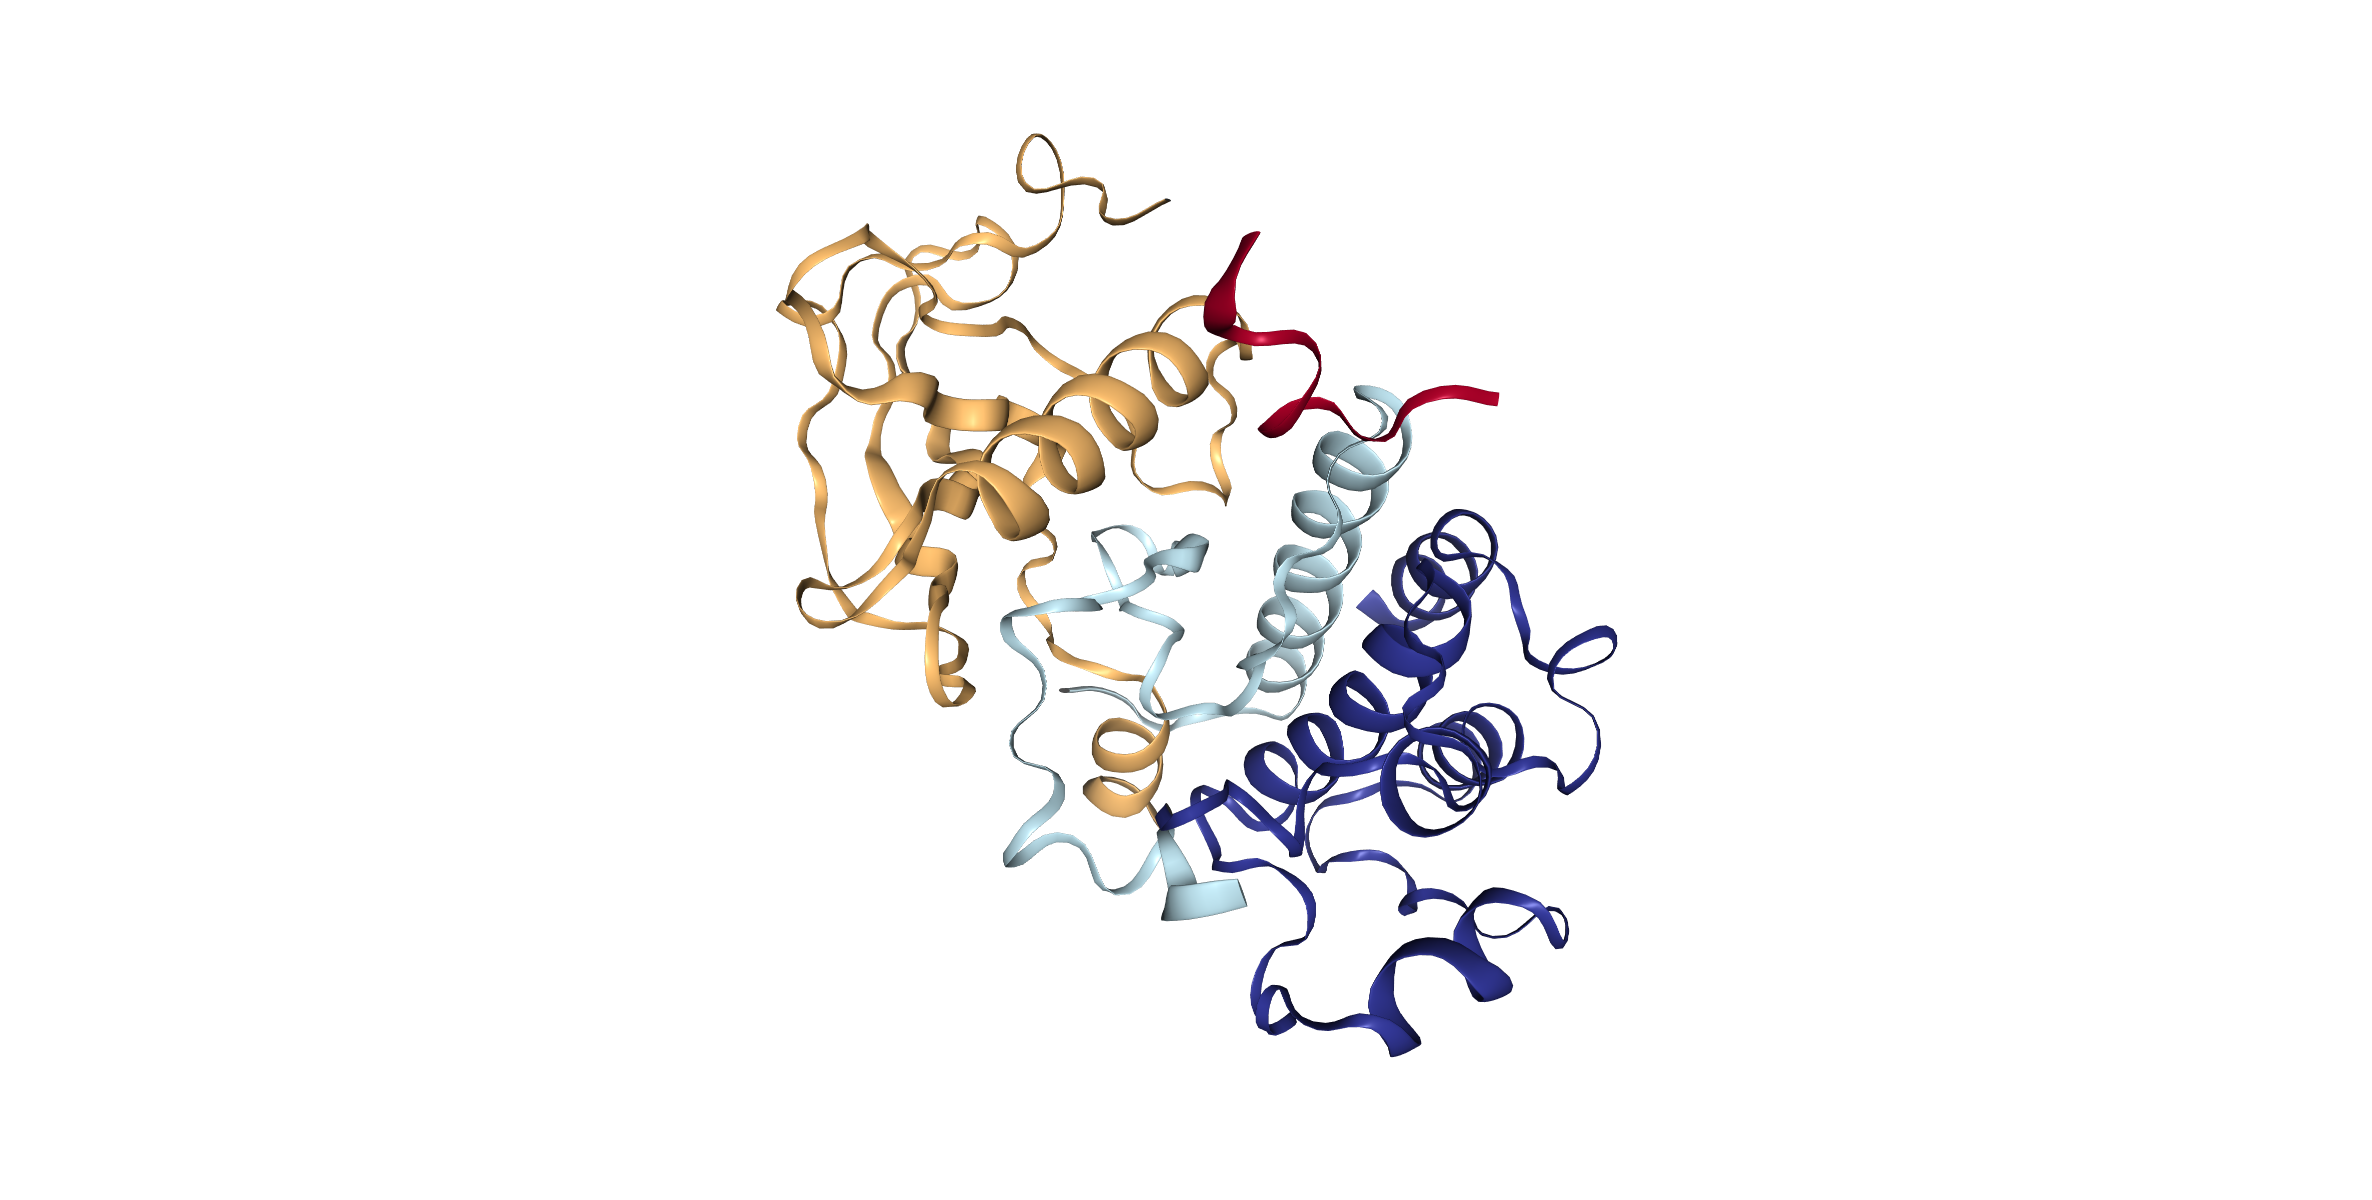

In [18]:
v._display_image()

Clc1ccc(NC(=O)c2c(NCc3ccncc3)cccc2)cc1


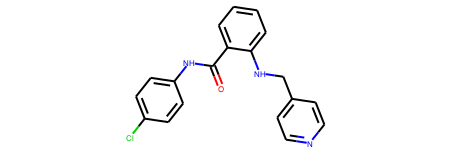

In [19]:
preview_smiles(ligands[0])

#### PubChemを検索

上で取得した`SMILES`文字列を使って、PubChemで類似の化合物を検索しましょう。

> ヒント：ChEMBLデータベースを使って似たような操作を行う方法は[Talktorial T1](https://github.com/volkamerlab/TeachOpenCADD/blob/master/talktorials/1_ChEMBL/T1_ChEMBL.ipynb) を参照してください。

In [20]:
import requests
def similar_compounds_pubchem(smiles, threshold=75, n_records=10):
    # 類似化合物をPubChemで検索する
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()['Waiting']['ListKey']
    # 応答は非同期なので、処理が終わったかどうか25秒間毎秒問い合わせます。
    attempts = 25
    while attempts:
        r = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON")
        r.raise_for_status()
        response = r.json()
        if 'IdentifierList' in response:
            cids = response['IdentifierList']['CID']
            break
        attempts -= 1
        time.sleep(1)
    else:
        raise IOError("Could not find matches for " + smiles)
    # 化合物IDを戻り値として得られますが、SMILESが必要です。
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item['CanonicalSMILES'] for item in r.json()['PropertyTable']['Properties']]

In [21]:
def query_pubchem_for_similar_compounds(ligands):
    # 現在のキナーゼの最初のリガンドを取得します。
    smiles = ligands[0]
    # PubChem上の最も類似した１０個の化合物を探します。
    return similar_compounds_pubchem(smiles, n_records=10)

取得した化合物をRDKitで描画します。

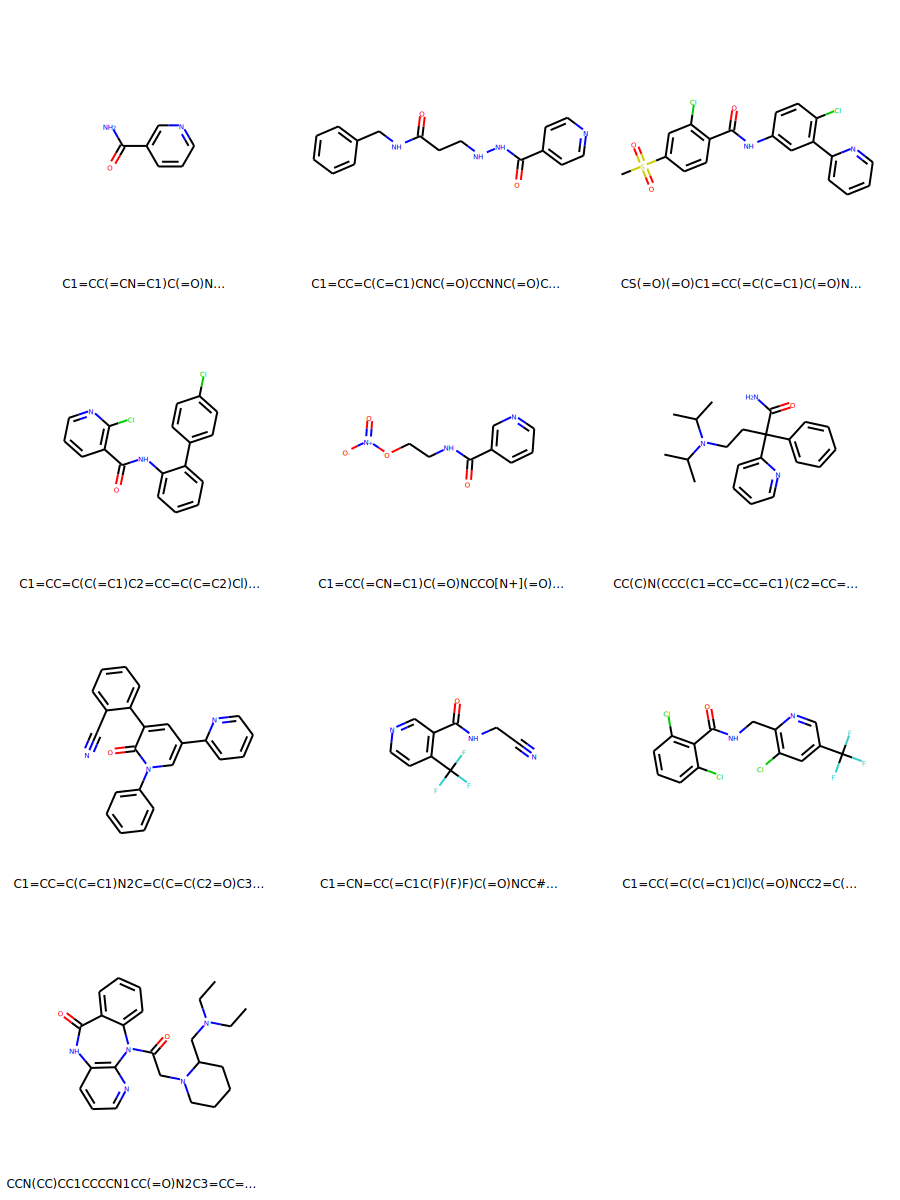

In [22]:
similar_smiles = query_pubchem_for_similar_compounds(ligands)
multi_preview_smiles(*similar_smiles)

### ケーススタディー: EGFR

対応する[Wikipediaの記事](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor)から改変して引用します。

> 上皮成長因子受容体（Epidermal Growth Factor Receptor; EGFR）はErbBファミリー受容体のメンバーで、密接に関係する４つの受容体チロシンキナーゼ、EGFR (ErbB-1)、HER2/neu (ErbB-2)、Her3 (ErbB-3)そしてHer4 (ErbB-4)のサブファミリーです。多くのがん種で、EGFRの発現あるいは活性に影響を与える変異が、発がんに繋がります。
> ヒトにおいてEGFRと他の受容体チロシンキナーゼのシグナルの欠損はアルツハイマー病といった疾患と関連づけられており、一方で過剰発現はさまざまな種類の腫瘍の発達と関連づけられています。受容体細胞外ドメインのEGFR結合サイトの阻害、あるいは細胞内のチロシンキナーゼ活性の阻害によるEGFRシグナルの遮断により、EGFRを発現する腫瘍の成長を阻害したり患者の症状を改善することができます。

つまり、私たちはEGFRファミリーのメンバーをターゲットとすることができる阻害剤の候補を探すことに興味があります。さあ、上記と同じステップを繰り返しましょう！但し今回はこの特定のキナーゼファミリーをターッゲトとします。

In [25]:
egfr_molcomplex, egfr_protein, egfr_ligands = kinase_structure_from_family('EGFR')

Chosen KLIFS entry with PDB ID 3w33 with chain A and alternate model A
Chosen EGFR kinase with ID 406 from family EGFR


**訳注(2020/05)**  
今回はたまたまオリジナルのノートブックと同じ結果が得られましたが、EGFRについては複数の構造が登録されているため、実行の度に取得されるPDB IDは異なります。  
**訳注ここまで**

タンパク質を試しに見てみましょう。

In [26]:
v = preview_molecule_contents(egfr_protein)
v

NGLWidget()

In [27]:
v.render_image(),

(Image(value=b'', width='99%'),)

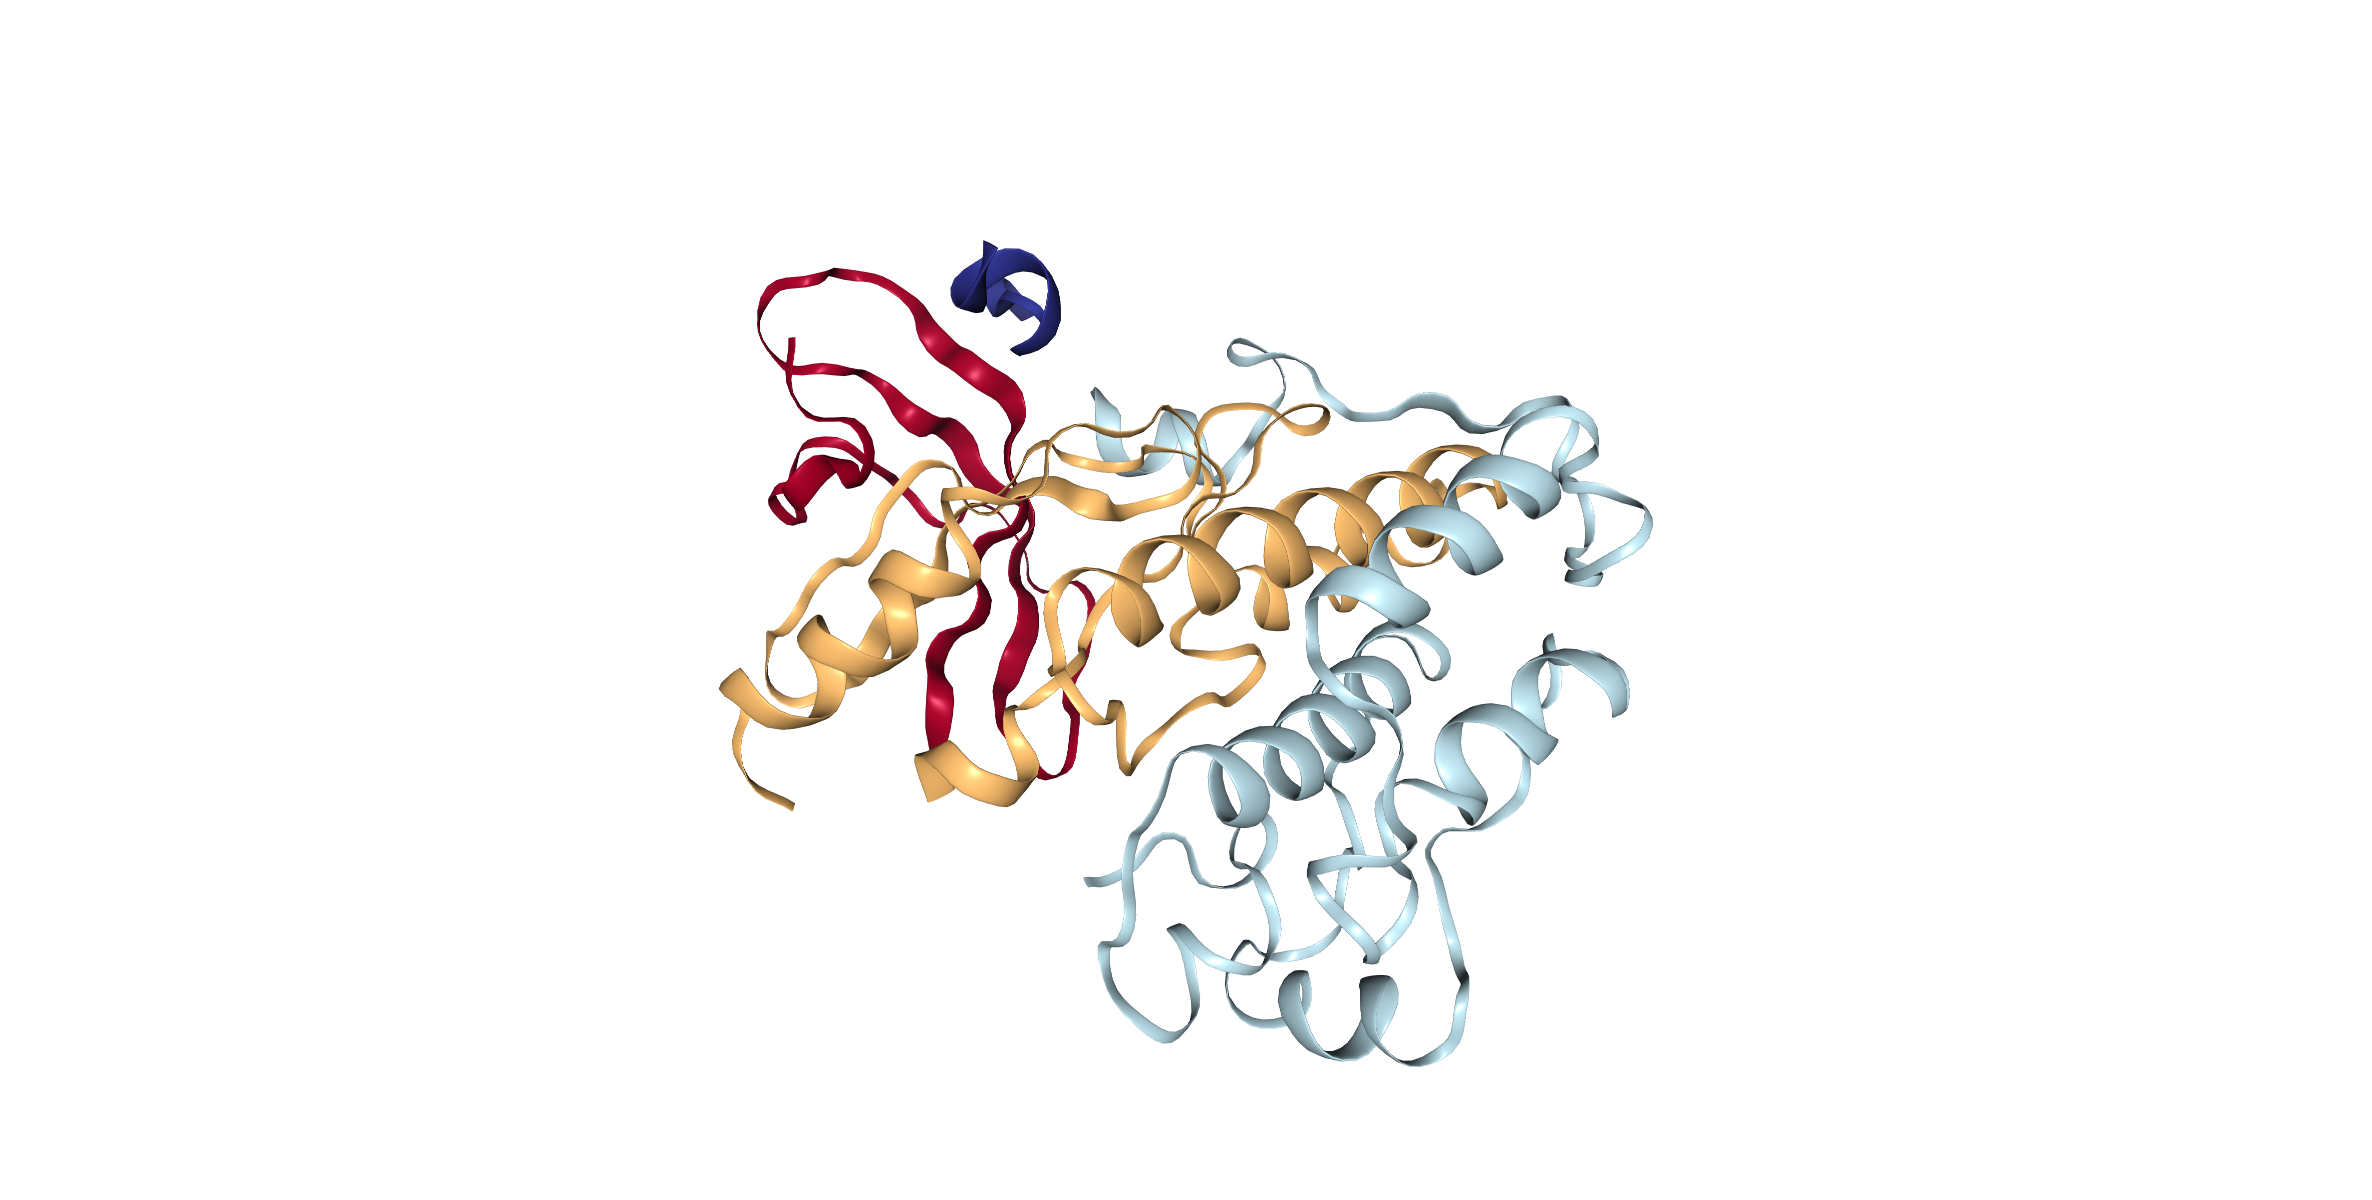

In [28]:
v._display_image()

EGFRのリガンド（ATP)を試しに見てみましょう。

P(=O)(OP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2)[C@H](O)[C@@H]1O)O


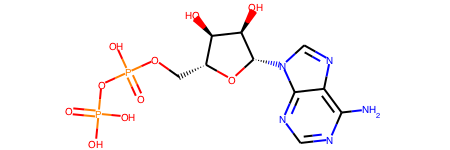

In [29]:
preview_smiles(egfr_ligands[0])

(**訳注** ADPの誤記だと思います。)

類似したリガンドを試しに見てみましょう。

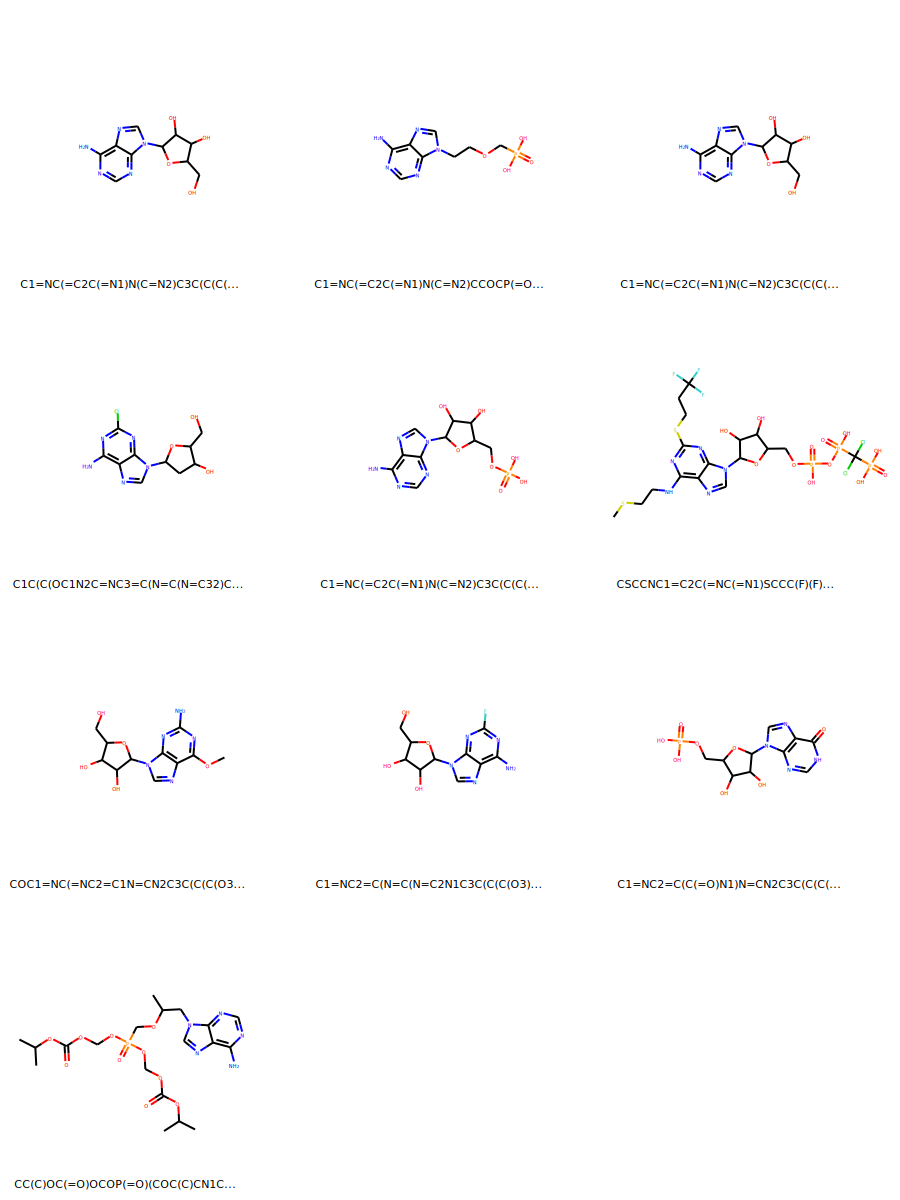

In [30]:
similar_smiles_egfr = query_pubchem_for_similar_compounds(egfr_ligands)
multi_preview_smiles(*similar_smiles_egfr)

トークトリアルの次のパートのためにディスクに結果を書き出しておきましょう！

In [31]:
import os
os.makedirs('data', exist_ok=True)
with open('data/similar_smiles.txt', 'w') as f:
    f.write('\n'.join(similar_smiles_egfr))
with open('data/protein.mol2', 'w') as f:
    f.write(egfr_protein)
with open('data/complex.pdb', 'w') as f:
    f.write(egfr_molcomplex)

***

## ディスカッション

このノートブックでは利用可能な技術に応じて異なるWebサービスにアクセスし使用する方法を学びました。きちんとした説明のあるAPIから、実際のWebブラウザーを真似しようとする手作りのスクレイパーまで取り上げました。

ここまで、KLIFSデータベースでEGFRファミリーのメンバーを検索し、キナーゼの構造と（当然のことながら）その内在性リガンドであるATPを取得しました。次に、PubChemから75%以上の類似度をもつ化合物を取得しました。次のパートではこれらの中から一つを選んで構造モデリングを実施します。

***

## クイズ

- "EGFR"ファミリーについてKLIFは幾つのキナーゼを提供しているでしょうか？
- 類似性検索をより厳密にすることはできますか？
- 提案された候補のなかにすでに承認された阻害剤はあるでしょうか？（ヒント：[PKIDB](http://www.icoa.fr/pkidb/)を_スクレイプ_して、SMILESのリストを確認することができます）